In [8]:
%pip install opencv-python matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


#### **Krok 1. Konwersja BGR -> RGB**
Biblioteka OpenCV domyślnie wczytuje obrazy w formacie BGR (Blue-Green-Red), podczas gdy standardowe biblioteki do wizualizacji (jak Matplotlib) oczekują formatu RGB (Red-Green-Blue). Bez zastosowania transformacji cv2.cvtColor, wyświetlany obraz miałby przekłamane kolory (np. czerwone elementy byłyby niebieskie), co utrudniłoby wizualną weryfikację poprawności działania algorytmu.

Wymiary obrazka: (720, 720, 3)


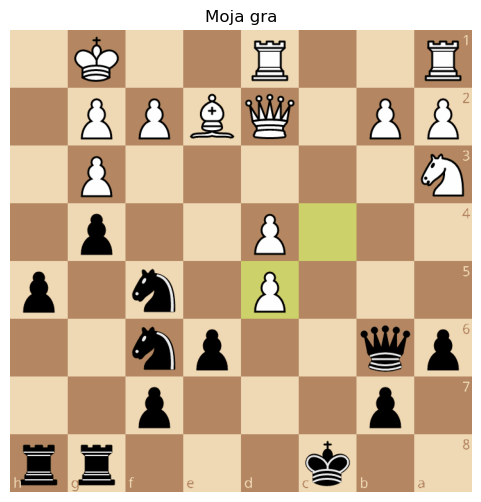

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def show_img(img, title="Obraz"):

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

game_img = cv2.imread('assets/sample/my_game.png')

if game_img is not None:
    print(f"Wymiary obrazka: {game_img.shape}") # (wysokość, szerokość, kanały)
    show_img(game_img, "Moja gra")
else:
    print("Nie znaleziono pliku!")

#### **Krok 2: Segmentacja obrazu planszy (Grid Slicing) i ekstrakcja pól.**
Dekompozycja jednolitego obrazu całej planszy (macierzy 720x720 pikseli) na zbiór 64 niezależnych podobrazów o wymiarach 90x90 pikseli. Wykorzystując iteracyjne pętle, wyznaczamy współrzędne graniczne dla każdego pola szachowego i wycinamy odpowiadające im fragmenty.

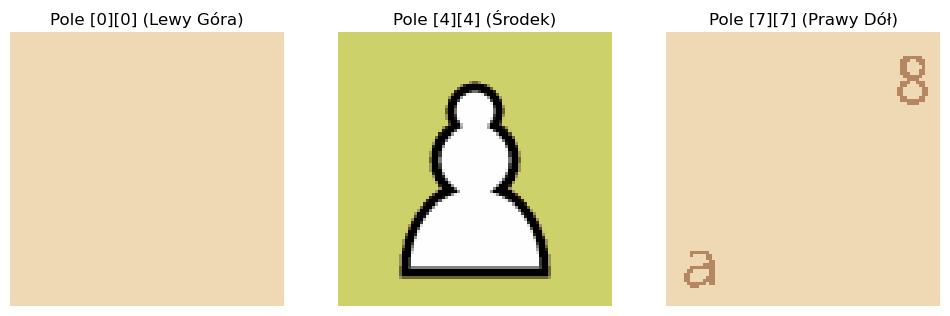

In [10]:
SQUARE_SIZE = 90

squares = []

# Tnięcie obrazu 
for row in range(8):
    row_squares = []
    for col in range(8):

        y_start = row * SQUARE_SIZE
        y_end = y_start + SQUARE_SIZE
        x_start = col * SQUARE_SIZE
        x_end = x_start + SQUARE_SIZE
        
        square = game_img[y_start:y_end, x_start:x_end]
        row_squares.append(square)
    squares.append(row_squares)

# --- SPRAWDZENIE WYNIKÓW ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Lewy górny róg (Puste pole)
axs[0].imshow(cv2.cvtColor(squares[0][0], cv2.COLOR_BGR2RGB))
axs[0].set_title("Pole [0][0] (Lewy Góra)")
axs[0].axis('off')

# Środek planszy (jakieś losowe pole)
axs[1].imshow(cv2.cvtColor(squares[4][4], cv2.COLOR_BGR2RGB))
axs[1].set_title("Pole [4][4] (Środek)")
axs[1].axis('off')

# Prawy dolny róg
axs[2].imshow(cv2.cvtColor(squares[7][7], cv2.COLOR_BGR2RGB))
axs[2].set_title("Pole [7][7] (Prawy Dół)")
axs[2].axis('off')

plt.show()

#### **Krok 3: Detekcja, klasyfikacja obiektów i wizualizacja wyników.**
Algorytm przetwarza macierz 8x8 pól w pętli, stosując hybrydowe podejście do klasyfikacji: wstępną analizę statystyczną (wariancja) do odróżnienia pól pustych od zajętych, a następnie dopasowanie wzorców (Template Matching) przy użyciu normy różnicowej TM_SQDIFF_NORMED. Dodatkowo zaimplementowano heurystyczną logikę ratunkową (fallback logic) dla obiektów o niskim kontraście (głównie czarnych pionków).

✅ Wczytano obraz: my_game.png
Rozpoczynam analizę planszy...
✅ Analiza zakończona pomyślnie.


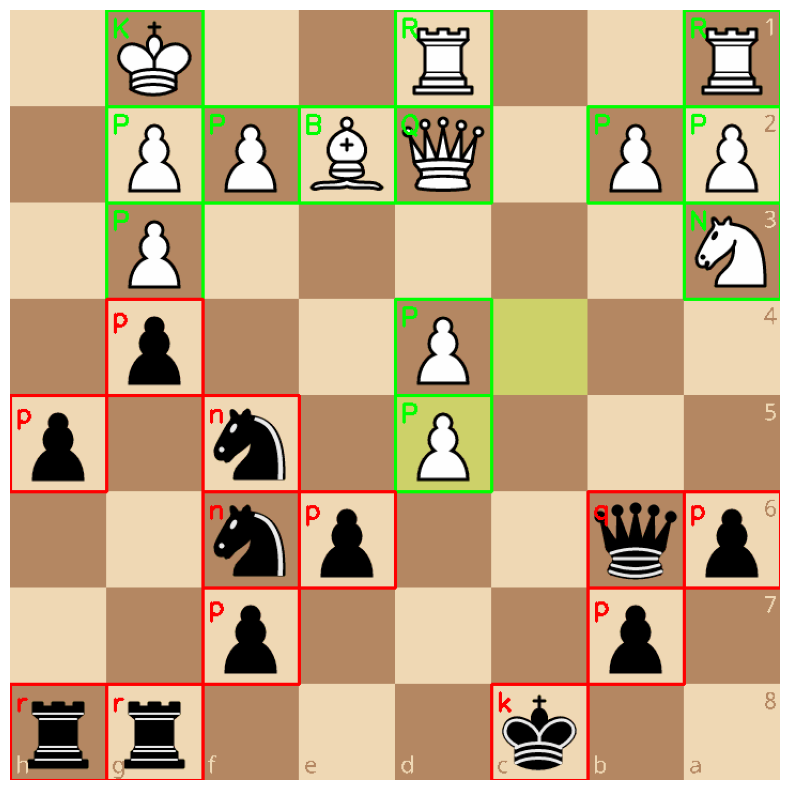

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- 1. KONFIGURACJA ---
NAZWA_PLIKU = 'my_game.png' 
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/png' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# --- 2. WCZYTANIE WZORCÓW ---
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue
    
    # Tworzenie twardej maski (dla lepszej detekcji krawędzi)
    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

# --- 3. WCZYTANIE OBRAZU GRY (Ten fragment jest niezbędny do działania reszty!) ---
full_path = os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU)
game_img = cv2.imread(full_path)

if game_img is None:
    print(f"❌ BŁĄD: Nie znaleziono pliku: {full_path}")
else:
    print(f"✅ Wczytano obraz: {NAZWA_PLIKU}")

    # Cięcie na 64 pola
    squares = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            y, x = row * 90, col * 90
            square = game_img[y:y+90, x:x+90]
            row_squares.append(square)
        squares.append(row_squares)

    # --- 4. FUNKCJE POMOCNICZE ---
    def is_square_empty(square_img, variance_threshold=20):
        """Sprawdza czy pole jest puste na podstawie odchylenia standardowego kolorów."""
        gray = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
        std_dev = np.std(gray)
        return std_dev < variance_threshold

    def identify_piece(square_img, threshold=0.60):
        """Rozpoznaje figurę metodą Template Matching (SQDIFF)."""
        best_confidence = -1.0
        best_symbol = None
        
        for symbol, data in templates.items():
            res = cv2.matchTemplate(square_img, data['img'], cv2.TM_SQDIFF_NORMED, mask=data['mask'])
            min_diff, _, _, _ = cv2.minMaxLoc(res)
            confidence = 1.0 - min_diff
            
            if confidence > best_confidence:
                best_confidence = confidence
                best_symbol = symbol
                
        if best_confidence < threshold:
            return None, best_confidence
        
        return best_symbol, best_confidence

    # --- 5. GŁÓWNA ANALIZA PLANSZY ---
    output_img = game_img.copy()
    board_str = [] 

    print("Rozpoczynam analizę planszy...")

    for row in range(8):
        row_str = []
        for col in range(8):
            square = squares[row][col]
            y, x = row * 90, col * 90
            
            # KROK A: Sprawdzenie czy pole jest puste
            if is_square_empty(square, variance_threshold=20):
                row_str.append('.')
                continue 
            
            # KROK B: Próba rozpoznania figury
            piece, score = identify_piece(square, threshold=0.60)
            
            # KROK C: Logika uzupełniająca (dla trudnych figur, np. czarnych pionów)
            if piece is None:
                # Jeśli pole nie jest puste, a figura nie została rozpoznana,
                # sprawdzamy czy to czarny pion z obniżonym progiem
                pawn_data = templates['p']
                res = cv2.matchTemplate(square, pawn_data['img'], cv2.TM_SQDIFF_NORMED, mask=pawn_data['mask'])
                min_diff, _, _, _ = cv2.minMaxLoc(res)
                pawn_confidence = 1.0 - min_diff
                
                if pawn_confidence > 0.45:
                    piece = 'p'
                else:
                    # Ostateczność: Zakładamy piona, skoro pole jest zajęte
                    piece = 'p' 

            # KROK D: Zapisanie wyniku i rysowanie
            if piece:
                row_str.append(piece)
                # Kolor ramki: Zielony (Białe), Czerwony (Czarne)
                color = (0, 255, 0) if piece.isupper() else (0, 0, 255)
                
                cv2.rectangle(output_img, (x, y), (x+90, y+90), color, 2)
                cv2.putText(output_img, piece, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        board_str.append(row_str)

    print("✅ Analiza zakończona pomyślnie.")


    img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

#### **Krok 4. Generowanie kodu FEM.**

In [5]:
def generate_fen(board_grid):
    """
    Konwertuje macierz planszy na standardowy ciąg FEN.
    """
    fen_parts = []
    
    for row in board_grid:
        empty_count = 0
        line = ""
        
        for char in row:
            if char == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    line += str(empty_count)
                    empty_count = 0
                line += char
        
        if empty_count > 0:
            line += str(empty_count)
            
        fen_parts.append(line)
        
    return "/".join(fen_parts) + " w KQkq - 0 1"

# --- UŻYCIE ---
if 'board_str' in locals():
    final_fen = generate_fen(board_str)
    
    print("\nKod FEN:")
    print(final_fen)
    print("-" * 30)
    print("Możesz go wkleić tutaj: https://lichess.org/analysis")
else:
    print("⚠️ Najpierw uruchom analizę obrazka!")


Kod FEN:
1K2R2R/1PPBQ1PP/1P5N/1p2P3/p1n1P3/2np2qp/2p3p1/rr3k2 w KQkq - 0 1
------------------------------
Możesz go wkleić tutaj: https://lichess.org/analysis


#### **TESTOWANIE INNYCH OBRAZKÓW** 

✅ Wczytano obraz: starting_board.png ((720, 720, 3))
Rozpoczynam analizę...

KOD FEN :
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


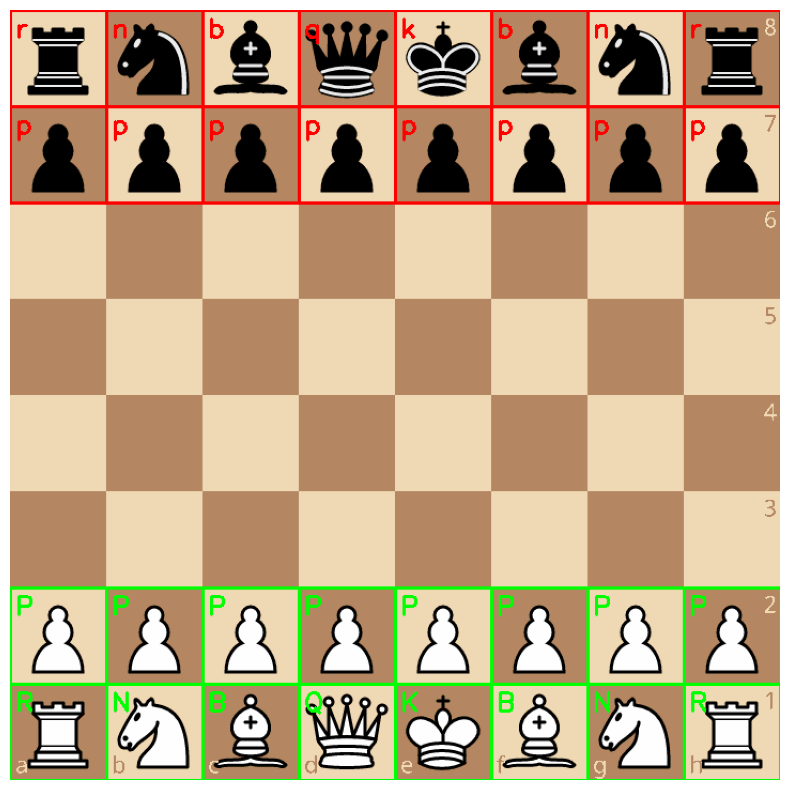

In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

NAZWA_PLIKU = 'starting_board.png' 
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/png' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# WCZYTANIE WZORCÓW
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue

    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

# WCZYTANIE OBRAZU GRY 
full_path = os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU)
game_img = cv2.imread(full_path)

if game_img is None:
    print(f"❌ BŁĄD: Nie znaleziono pliku: {full_path}")
else:
    print(f"✅ Wczytano obraz: {NAZWA_PLIKU} ({game_img.shape})")

    squares = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            y, x = row * 90, col * 90
            square = game_img[y:y+90, x:x+90]
            row_squares.append(square)
        squares.append(row_squares)

    # ANALIZA PLANSZY
    output_img = game_img.copy()
    board_str = []
    
    print("Rozpoczynam analizę...")

    for row in range(8):
        row_str = []
        for col in range(8):
            square = squares[row][col]
            y, x = row * 90, col * 90
            
            gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
            if np.std(gray) < 20:
                row_str.append('.')
                continue 
            
            best_confidence = -1.0
            best_symbol = None
            for symbol, data in templates.items():
                res = cv2.matchTemplate(square, data['img'], cv2.TM_SQDIFF_NORMED, mask=data['mask'])
                min_diff, _, _, _ = cv2.minMaxLoc(res)
                confidence = 1.0 - min_diff
                if confidence > best_confidence:
                    best_confidence = confidence
                    best_symbol = symbol
            
            piece = best_symbol if best_confidence >= 0.60 else None

            if piece is None:
                piece = 'p'

            if piece:
                row_str.append(piece)
                color = (0, 255, 0) if piece.isupper() else (0, 0, 255)
                cv2.rectangle(output_img, (x, y), (x+90, y+90), color, 2)
                cv2.putText(output_img, piece, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        board_str.append(row_str)

    # FEM
    def get_fen(grid):
        fen_parts = []
        for row in grid:
            empty = 0
            line = ""
            for char in row:
                if char == '.': empty += 1
                else:
                    if empty > 0: line += str(empty); empty = 0
                    line += char
            if empty > 0: line += str(empty)
            fen_parts.append(line)
        return "/".join(fen_parts) + " w KQkq - 0 1"

    fen_result = get_fen(board_str)


    print("\nKOD FEN :")
    print(f"{fen_result}")


    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()